In [1]:
#alguns imports

import sys
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1653469420617_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:

#criar uma instância SparkSession

spark = SparkSession\
    .builder\
    .appName("Dataset")\
    .config("spark.sql.shuffle.partitions",6)\
    .config("spark.sql.repl.eagerEval.enabled", True)\
    .getOrCreate()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:

#leitura do dataset
df_raw = spark.read.csv("s3://bigdatanoaa/Dataset/", header="false", inferSchema="true", sep=",")   

#renomear as colunas
df_raw = df_raw.toDF("ID", "DATE", "ELEMENT", "DATA VALUE", "MFLAG", "QFLAG", "SFLAG", "OBS_TIME") 


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:

#colunas irrelevantes
cols_to_drop = ['MFLAG', 'QFLAG', 'SFLAG', 'OBS_TIME']

#colunas de interesse
cols_interest = [x for x in df_raw.columns if x not in cols_to_drop]

#eliminação das colunas irrelevantes
df_raw_interest = df_raw.select(cols_interest)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:

# Os valores correspondentes às temperaturas e preciciptação apresentam inicialmente um formato de tenth of degrees
# É preciso dividir esses valores por 10 de modo a obter o valor em graus centígrados

df_raw_interest = df_raw_interest.withColumn("DATA VALUE",
    when((col("ELEMENT") == "TMAX")|(col("ELEMENT") == "TMIN")|(col("ELEMENT") == "TAVG")|(col("ELEMENT") == "PRCP"),
    round((col("DATA VALUE")/10),2)).otherwise(col("DATA VALUE")))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:

#Passagem das datas para forma de string de modo a conseguirmos separar o ano, mês e dia
df_ano = df_raw_interest.withColumn("DATE",col("DATE").cast(StringType()))

#Filtragem de modo a obter os dados relativos a Portugal no ano 2019
df_ano = df_ano.filter((col("DATE").substr(1,4) == "2019") & (col("ID").substr(1,2) == "PO"))

#Obtenção dos valores relativos à temperatura máxima
df_max = df_ano.filter(col("ELEMENT") == "TMAX")
#Agrupamos os dados por mês, obtendo o valor máximo de temperatura para cada mês
df_max = df_max.groupBy(col("DATE").substr(5,2)).max("DATA VALUE")
#Ordenação dos dados por ordem crescente de mês
df_max = df_max.orderBy(col("substring(DATE, 5, 2)"))

#Obtenção dos valores relativos à temperatura média
df_avg = df_ano.filter(col("ELEMENT") == "TAVG")
#Agrupamos os dados por mês, obtendo o valor médio de temperatura para cada mês
df_avg = df_avg.groupBy(col("DATE").substr(5,2)).avg("DATA VALUE")
#Ordenação dos dados por ordem crescente de mês
df_avg = df_avg.orderBy(col("substring(DATE, 5, 2)"))

#Obtenção dos valores relativos à temperatura máxima
df_min = df_ano.filter(col("ELEMENT") == "TMIN")
#Agrupamos os dados por mês, obtendo o valor mínimo de temperatura para cada mês
df_min = df_min.groupBy(col("DATE").substr(5,2)).min("DATA VALUE")
#Ordenação dos dados por ordem crescente de mês
df_min = df_min.orderBy(col("substring(DATE, 5, 2)"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

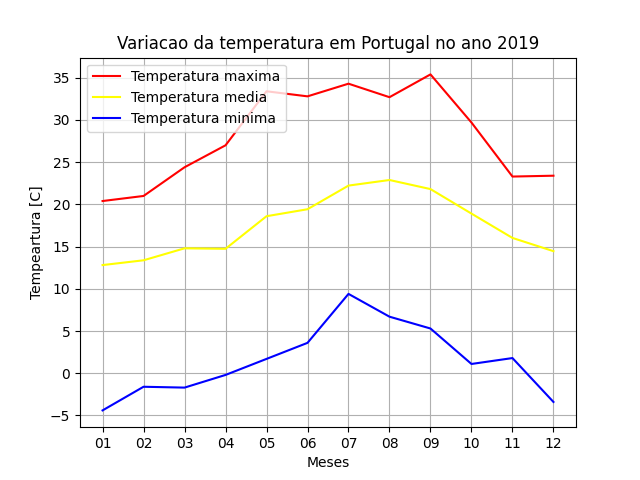

In [7]:

#São feitos os imports novamente de modo a permitir a visualização do gráfico
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Construção do gráfico de variação da temperatura em Portugal no ano 2019
plt.plot(figsize=(28,8))
sns.lineplot(y="max(DATA VALUE)",x="substring(DATE, 5, 2)",data=df_max.toPandas(),label="Temperatura maxima",color="red")
sns.lineplot(y="avg(DATA VALUE)",x="substring(DATE, 5, 2)",data=df_avg.toPandas(),label="Temperatura media",color="yellow")
sns.lineplot(y="min(DATA VALUE)",x="substring(DATE, 5, 2)",data=df_min.toPandas(),label="Temperatura minima",color="blue")
plt.title("Variacao da temperatura em Portugal no ano 2019")
plt.xlabel("Meses")
plt.ylabel("Tempeartura [C]")
plt.legend()
plt.grid()
plt.show()

#Comando local para permitir a visualização do gráfico
%matplot plt
